Matplotlib is building the font cache; this may take a moment.


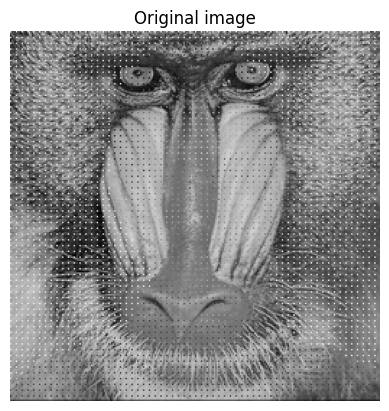

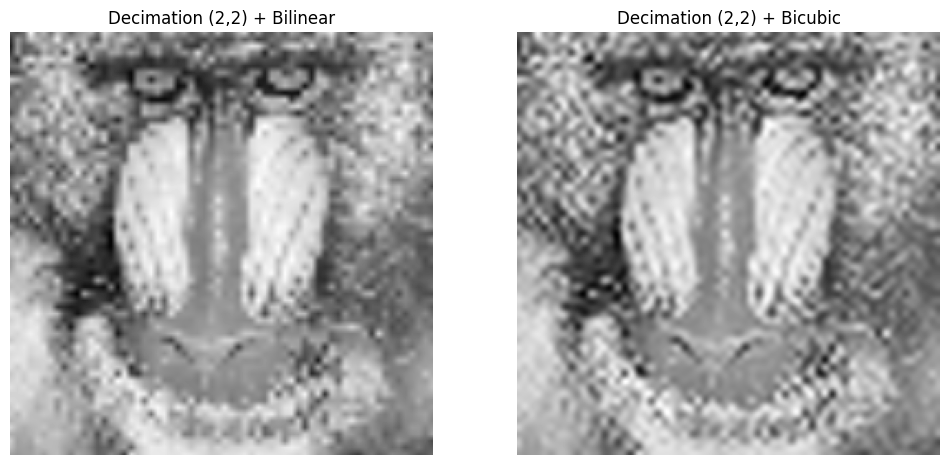

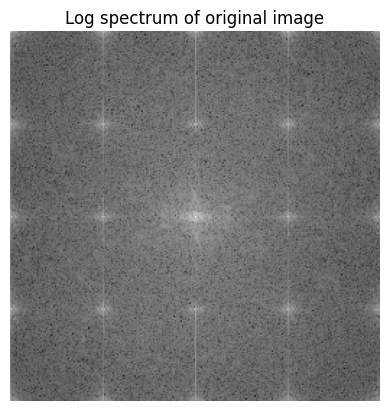

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

# ---- Load image (upload manually via JupyterLite file browser) ----
# Example: put "mono.bmp" in the same directory as your notebook
img = Image.open("mono.bmp").convert("L")  # grayscale
img_np = np.array(img)

plt.imshow(img_np, cmap="gray")
plt.title("Original image")
plt.axis("off")
plt.show()

# ---- (a) Decimation: keep (2,2) pixel from each 4x4 block ----
def decimate_block(img, method="pick_22"):
    h, w = img.shape
    h4, w4 = h // 4, w // 4
    out = np.zeros((h4, w4))
    for i in range(h4):
        for j in range(w4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            if method == "pick_22":
                out[i, j] = block[1, 1]  # (2,2) in MATLAB indexing
            elif method == "pick_11":
                out[i, j] = block[0, 0]
            elif method == "average":
                out[i, j] = np.mean(block)
    return out

dec_22 = decimate_block(img_np, "pick_22")
dec_11 = decimate_block(img_np, "pick_11")
dec_avg = decimate_block(img_np, "average")

# ---- (d) Interpolation back to original size ----
def resize_interp(img_small, target_shape, method="bilinear"):
    zoom_y = target_shape[0] / img_small.shape[0]
    zoom_x = target_shape[1] / img_small.shape[1]
    order = 1 if method == "bilinear" else 3
    return ndimage.zoom(img_small, (zoom_y, zoom_x), order=order)

rec_22_bilinear = resize_interp(dec_22, img_np.shape, "bilinear")
rec_22_bicubic  = resize_interp(dec_22, img_np.shape, "bicubic")

# ---- Show results ----
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(rec_22_bilinear, cmap="gray")
plt.title("Decimation (2,2) + Bilinear")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rec_22_bicubic, cmap="gray")
plt.title("Decimation (2,2) + Bicubic")
plt.axis("off")
plt.show()

# ---- Spectrum of original ----
f = np.fft.fftshift(np.fft.fft2(img_np))
spectrum = np.log(1 + np.abs(f))

plt.imshow(spectrum, cmap="gray")
plt.title("Log spectrum of original image")
plt.axis("off")
plt.show()


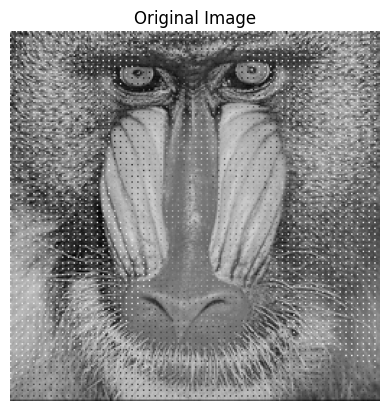

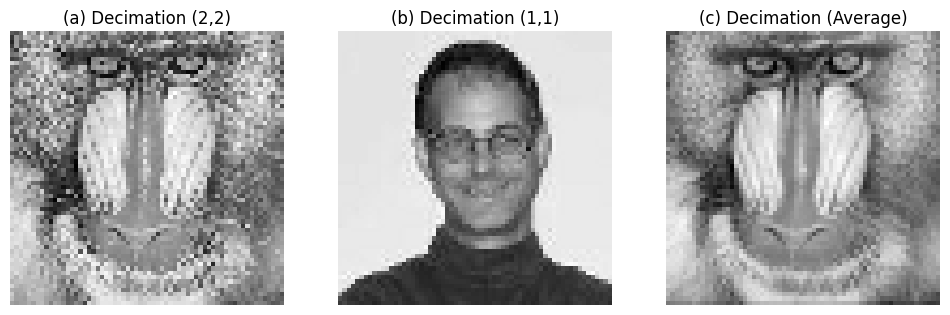

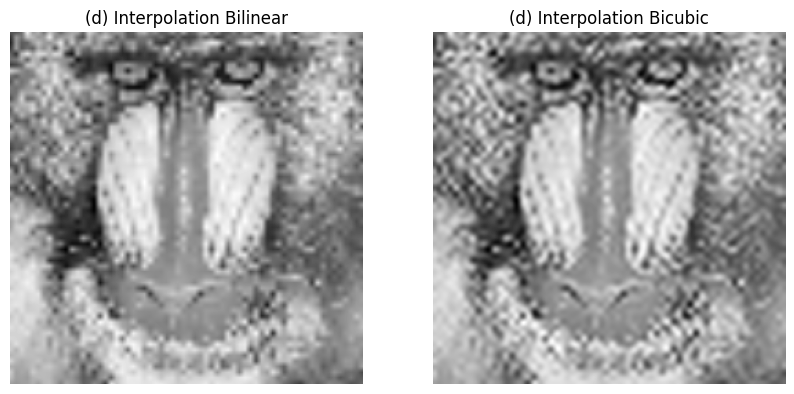

=== MSE & PSNR Results ===
Dec (2,2) + Bilinear      | MSE = 1064.58 | PSNR = 17.86 dB
Dec (2,2) + Bicubic       | MSE = 1175.58 | PSNR = 17.43 dB


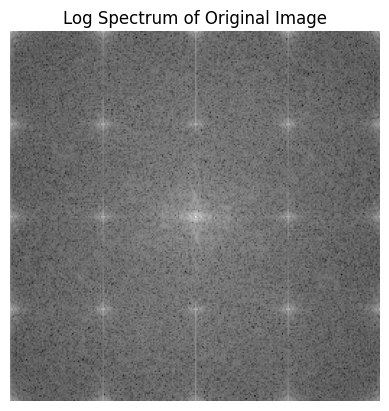

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

# ---- Load grayscale image (upload "mono.bmp" via JupyterLite file browser) ----
img = Image.open("mono.bmp").convert("L")
img_np = np.array(img)

plt.figure()
plt.imshow(img_np, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

# ---------------------
# (a) DECIMATION
# ---------------------
def decimate_block(img, method="pick_22"):
    h, w = img.shape
    h4, w4 = h // 4, w // 4
    out = np.zeros((h4, w4))
    for i in range(h4):
        for j in range(w4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            if method == "pick_22":   # pixel (2,2) in MATLAB -> (1,1) in Python
                out[i, j] = block[1, 1]
            elif method == "pick_11": # pixel (1,1) in MATLAB -> (0,0)
                out[i, j] = block[0, 0]
            elif method == "average":
                out[i, j] = np.mean(block)
    return out

dec_22  = decimate_block(img_np, "pick_22")
dec_11  = decimate_block(img_np, "pick_11")
dec_avg = decimate_block(img_np, "average")

plt.figure(figsize=(12,4))
for k, (dimg, title) in enumerate([(dec_22,"(a) Decimation (2,2)"),
                                   (dec_11,"(b) Decimation (1,1)"),
                                   (dec_avg,"(c) Decimation (Average)")]):
    plt.subplot(1,3,k+1)
    plt.imshow(dimg, cmap="gray")
    plt.title(title)
    plt.axis("off")
plt.show()

# ---------------------
# (d) INTERPOLATION
# ---------------------
def resize_interp(img_small, target_shape, method="bilinear"):
    zoom_y = target_shape[0] / img_small.shape[0]
    zoom_x = target_shape[1] / img_small.shape[1]
    order = 1 if method == "bilinear" else 3
    return ndimage.zoom(img_small, (zoom_y, zoom_x), order=order)

rec_22_bilinear = resize_interp(dec_22, img_np.shape, "bilinear")
rec_22_bicubic  = resize_interp(dec_22, img_np.shape, "bicubic")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rec_22_bilinear, cmap="gray")
plt.title("(d) Interpolation Bilinear")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rec_22_bicubic, cmap="gray")
plt.title("(d) Interpolation Bicubic")
plt.axis("off")
plt.show()

# ---------------------
# MSE & PSNR COMPARISON
# ---------------------
def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def psnr(img1, img2):
    m = mse(img1, img2)
    if m == 0:
        return float("inf")
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(m))

results = [
    ("Dec (2,2) + Bilinear", mse(img_np, rec_22_bilinear), psnr(img_np, rec_22_bilinear)),
    ("Dec (2,2) + Bicubic",  mse(img_np, rec_22_bicubic),  psnr(img_np, rec_22_bicubic))
]

print("=== MSE & PSNR Results ===")
for name, m, p in results:
    print(f"{name:25s} | MSE = {m:.2f} | PSNR = {p:.2f} dB")

# ---------------------
# SPECTRUM ANALYSIS
# ---------------------
f = np.fft.fftshift(np.fft.fft2(img_np))
spectrum = np.log(1 + np.abs(f))

plt.figure()
plt.imshow(spectrum, cmap="gray")
plt.title("Log Spectrum of Original Image")
plt.axis("off")
plt.show()


<ipython-input-4-2256599d4736>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread("mono.bmp", pilmode="L").astype(float)


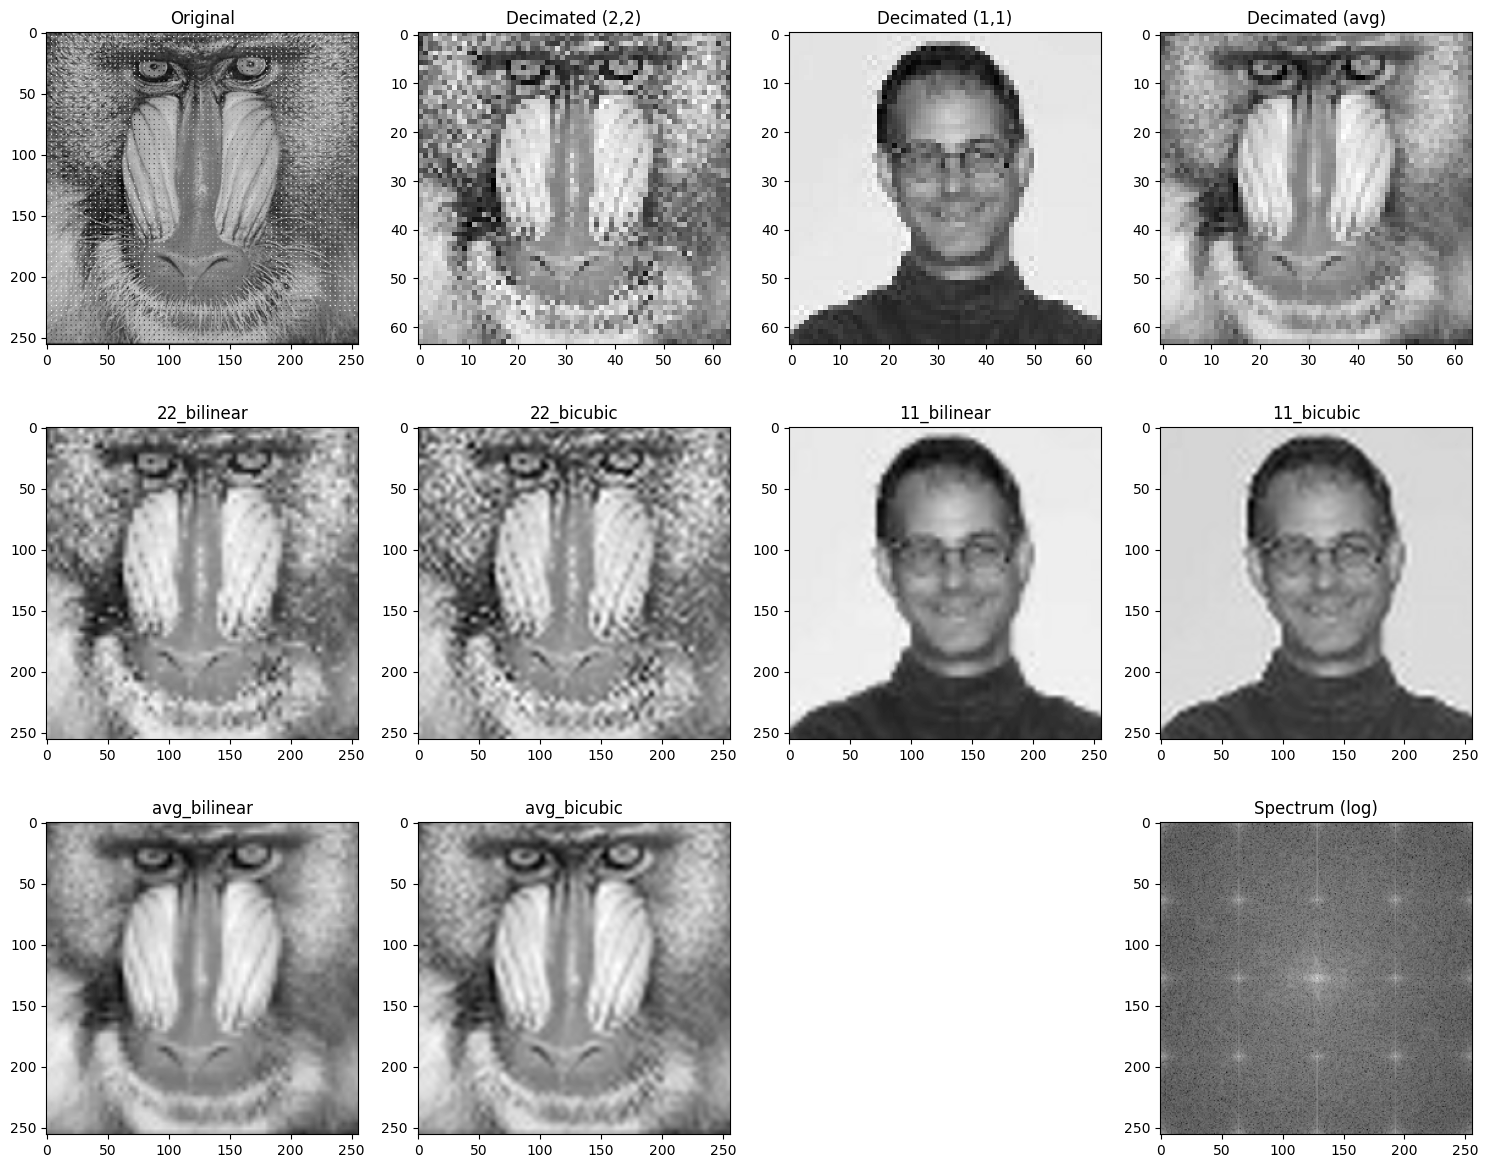

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from scipy.ndimage import zoom
from numpy.fft import fft2, fftshift

# --- Load grayscale image ---
img = imread("mono.bmp", pilmode="L").astype(float)
H, W = img.shape

# --- Helper: decimate with choice ---
def decimate(img, mode="22"):
    H, W = img.shape
    h, w = H//4, W//4
    out = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            if mode == "22":
                out[i, j] = block[1, 1]   # (2,2) in 1-based
            elif mode == "11":
                out[i, j] = block[0, 0]   # (1,1) in 1-based
            elif mode == "avg":
                out[i, j] = block.mean()
    return out

# --- Decimations ---
dec_22 = decimate(img, "22")
dec_11 = decimate(img, "11")
dec_avg = decimate(img, "avg")

# --- Helper: interpolate with scipy zoom ---
def interpolate(img_dec, scale, order):
    return zoom(img_dec, scale, order=order)

scale = (H/dec_22.shape[0], W/dec_22.shape[1])

# Reconstructed images (bilinear=1, bicubic=3)
recon = {
    "22_bilinear": interpolate(dec_22, scale, 1),
    "22_bicubic": interpolate(dec_22, scale, 3),
    "11_bilinear": interpolate(dec_11, scale, 1),
    "11_bicubic": interpolate(dec_11, scale, 3),
    "avg_bilinear": interpolate(dec_avg, scale, 1),
    "avg_bicubic": interpolate(dec_avg, scale, 3)
}

# --- Spectrum of original ---
F = fftshift(fft2(img))
spectrum = np.log(1 + np.abs(F))

# --- Plot results ---
plt.figure(figsize=(15, 12))

plt.subplot(3,4,1)
plt.imshow(img, cmap="gray")
plt.title("Original")

plt.subplot(3,4,2)
plt.imshow(dec_22, cmap="gray")
plt.title("Decimated (2,2)")

plt.subplot(3,4,3)
plt.imshow(dec_11, cmap="gray")
plt.title("Decimated (1,1)")

plt.subplot(3,4,4)
plt.imshow(dec_avg, cmap="gray")
plt.title("Decimated (avg)")

i = 5
for k, v in recon.items():
    plt.subplot(3,4,i)
    plt.imshow(v, cmap="gray")
    plt.title(k)
    i += 1

plt.subplot(3,4,12)
plt.imshow(spectrum, cmap="gray")
plt.title("Spectrum (log)")

plt.tight_layout()
plt.show()


In [ ]:
"""1. Effect of different decimation strategies

(2,2) and (1,1) pixel picking:
These look like coarse versions of the original, but they depend on which pixel is chosen inside each 4×4 block. 
The (2,2) choice may retain a little more structure if the image has smooth changes, but both approaches throw 
away most information, so details and edges are badly lost.

Averaging:
The average preserves global brightness and reduces aliasing compared to picking a single pixel. 
The image looks smoother and more faithful, but also blurrier.

2. Reconstruction with bilinear vs bicubic interpolation

Bilinear interpolation:
Produces smoother images, but edges look washed out. It is fast and computationally simple, but the reconstructed images 
look blurry.

Bicubic interpolation:
Produces sharper results with better edge definition and contrast. However, it may also introduce small ringing 
artifacts around edges. For these decimated images, bicubic gives a visibly closer reconstruction to the original 
than bilinear.

3. Comparing decimation + interpolation combinations

Pixel-based decimation (2,2 or 1,1) + interpolation:
The reconstructions show noticeable checkerboard patterns and aliasing. Fine details from the original cannot be 
recovered since the sampling was too aggressive.

Averaging + interpolation:
This produces the best subjective reconstruction. Although it is blurrier, aliasing is reduced, and bicubic 
interpolation helps recover a visually smoother and more natural image.

4. Spectrum analysis

The spectrum of the original shows the natural distribution of frequencies.

After decimation, much of the high-frequency content is lost. If a single pixel is chosen (2,2 or 1,1), 
aliasing appears because high frequencies are folded into lower frequencies.

With averaging, the high-frequency content is attenuated before downsampling, which reduces aliasing. 
This is why its reconstructions look cleaner.

Final conclusions

The choice of decimation strategy has a bigger impact than the choice of interpolation method.

Averaging before downsampling is the best approach because it reduces aliasing and leads to more natural reconstructions.

Between interpolation methods, bicubic is superior to bilinear, especially for restoring edges and fine structures, 
although it cannot recover frequencies that were already lost.

The combination (averaging + bicubic interpolation) provides the best visual result among the tested methods."""